In [27]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label

import gc
gc.enable()

In [28]:
# Train and test directories
train_image_dir = "E:/train_v2"
test_image_dir = "E:/test_v2"

In [29]:
# Getting into train directory
train_images = os.listdir(train_image_dir)
train_images.sort()
print(f"Total of {len(train_images)} images in train directory.\nHere is how first five train_images looks like:- {train_images[:5]}")

Total of 192556 images in train directory.
Here is how first five train_images looks like:- ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg', '000194a2d.jpg', '0001b1832.jpg']


In [30]:
# Train ships segmented masks
masks = pd.read_csv('C:/Users/krish/Downloads/train_ship_segmentations_v2.csv')


In [31]:
# Define functions to do these tasks for all the training images
def rle_decode(mask_rle, shape=(768,768)):
    '''
    Input arguments -
    mask_rle: Mask of one ship in the train image
    shape: Output shape of the image array
    '''
    s = mask_rle.split()                                                               # Split the mask of each ship that is in RLE format
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]     # Get the start pixels and lengths for which image has ship
    ends = starts + lengths - 1                                                        # Get the end pixels where we need to stop
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)                                  # A 1D vec full of zeros of size = 768*768
    for lo, hi in zip(starts, ends):                                                   # For each start to end pixels where ship exists
        img[lo:hi+1] = 1                                                               # Fill those values with 1 in the main 1D vector
    '''
    Returns -
    Transposed array of the mask: Contains 1s and 0s. 1 for ship and 0 for background
    '''
    return img.reshape(shape).T                                                       

def masks_as_image(in_mask_list):
    '''
    Input - 
    in_mask_list: List of the masks of each ship in one whole training image
    '''
    all_masks = np.zeros((768, 768), dtype = np.int16)                                 # Creating 0s for the background
    for mask in in_mask_list:                                                          # For each ship rle data in the list of mask rle 
        if isinstance(mask, str):                                                      # If the datatype is string
            all_masks += rle_decode(mask)                                              # Use rle_decode to create one mask for whole image
    '''
    Returns - 
    Full mask of the training image whose RLE data has been passed as an input
    '''
    return np.expand_dims(all_masks, -1)

In [32]:
'''Note that NaN values in the EncodedPixels are of float type and everything else is a string type'''   

# Add a new feature to the masks data frame named as ship. If Encoded pixel in any row is a string, there is a ship else there isn't. 
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
masks.head(9)

,ImageId,EncodedPixels,ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,1
8,0001b1832.jpg,NaN,0


In [33]:
# Making a new data frame with unique image ids where we are summing up the ship counts
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index() 
unique_img_ids.index+=1 # Incrimenting all the index by 1
unique_img_ids.head()

,ImageId,ships
1,00003e153.jpg,0
2,0001124c7.jpg,0
3,000155de5.jpg,1
4,000194a2d.jpg,5
5,0001b1832.jpg,0


In [34]:
# Adding two new features to unique_img_ids data frame. If ship exists in image, val is 1 else 0. And it's vec form
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids.head()

,ImageId,ships,has_ship
1,00003e153.jpg,0,0.0
2,0001124c7.jpg,0,0.0
3,000155de5.jpg,1,1.0
4,000194a2d.jpg,5,1.0
5,0001b1832.jpg,0,0.0


In [35]:
# Check the size of the files. Will take some time to run as there are loads of files!!!
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)
'''os.stat is used to get status of the specified path. Here, st_size represents size of the file in bytes. Converting it into kB!'''

'os.stat is used to get status of the specified path. Here, st_size represents size of the file in bytes. Converting it into kB!'

In [36]:
# We can get rid of any images whose size is less than 35 Kb. As some of the files are corrupted! 
unique_img_ids[unique_img_ids.file_size_kb<35].head()

,ImageId,ships,has_ship,file_size_kb
85,001bfb70a.jpg,0,0.0,22.796875
359,0080bd6a5.jpg,0,0.0,14.327148
819,011589d1f.jpg,0,0.0,20.317383
1434,01df54887.jpg,0,0.0,16.492188
2342,0318fc519.jpg,0,0.0,13.289062


In [37]:
# Keep the files whose size > 35 kB
unique_img_ids = unique_img_ids[unique_img_ids.file_size_kb > 35]
unique_img_ids.head()

,ImageId,ships,has_ship,file_size_kb
1,00003e153.jpg,0,0.0,128.944336
2,0001124c7.jpg,0,0.0,76.059570
3,000155de5.jpg,1,1.0,147.625977
4,000194a2d.jpg,5,1.0,75.221680
5,0001b1832.jpg,0,0.0,95.627930


In [38]:
# Also, retrive the old masks data frame
masks.drop(['ships'], axis=1, inplace=True)
masks.index+=1 
masks.head()

,ImageId,EncodedPixels
1,00003e153.jpg,NaN
2,0001124c7.jpg,NaN
3,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
4,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
5,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [39]:
# Train - Test split
from sklearn.model_selection import train_test_split                   
train_ids, valid_ids = train_test_split(unique_img_ids, test_size = 0.3, stratify = unique_img_ids['ships'])

In [40]:
# Create train data frame
train_df = pd.merge(masks, train_ids)

# Create test data frame
valid_df = pd.merge(masks, valid_ids)

In [41]:
print("There are ~")
print(train_df.shape[0], 'training masks,')
print(valid_df.shape[0], 'validation masks.')

There are ~
162039 training masks,
69447 validation masks.


In [42]:
# Clipping the max value of grouped_ship_count to be 7, minimum to be 0
train_df['grouped_ship_count'] = train_df.ships.map(lambda x: (x+1)//2).clip(0,7)

In [43]:
# Check
train_df.grouped_ship_count.value_counts()

0    104837
1     29713
2     10744
3      6000
4      3772
5      2710
6      2155
7      2108
Name: grouped_ship_count, dtype: int64

In [44]:
# Random Under-Sampling ships
def sample_ships(in_df, base_rep_val=1500):
    '''
    Input Args:
    in_df - dataframe we want to apply this function
    base_val - random sample of this value to be taken from the data frame
    '''
    if in_df['ships'].values[0]==0:                                                 
        return in_df.sample(base_rep_val//3)  # Random 1500//3 = 500 samples taken whose ship count is 0 in an image 
    else:                                 
        return in_df.sample(base_rep_val)    # Random 1500 samples taken whose ship count is not 0 in an image

In [45]:
# Creating groups of ship counts and applying the sample_ships functions to randomly undersample the ships
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df.grouped_ship_count.value_counts() # In each group we have total of 1500 ships except 0 as we have decreased it even more to 500

7    1500
6    1500
5    1500
4    1500
3    1500
2    1500
1    1500
0     500
Name: grouped_ship_count, dtype: int64

In [46]:
# Explaining what we just did if still not clear
for i in range(8):
    df_val_counts = balanced_train_df[balanced_train_df.grouped_ship_count==i].ships.value_counts()
    print(f"Data frame for grouped ship count = {i}:-\n{df_val_counts}\nSum of Values:- {df_val_counts.values.sum()}\n\n")


Data frame for grouped ship count = 0:-
0    500
Name: ships, dtype: int64
Sum of Values:- 500


Data frame for grouped ship count = 1:-
1    982
2    518
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 2:-
3    871
4    629
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 3:-
5    803
6    697
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 4:-
7    816
8    684
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 5:-
9     866
10    634
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 6:-
11    782
12    718
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 7:-
14    534
15    492
13    474
Name: ships, dtype: int64
Sum of Values:- 1500




In [47]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.10.0rc0, 2.10.0rc1, 2.10.0)
ERROR: No matching distribution found for keras==2.5


In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import montage
from skimage.segmentation import mark_boundaries

from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import keras.backend as K

import segmentation_models as sm

# Parameters
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 100
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
NET_SCALING = None
IMG_SCALING = (1, 1)
VALID_IMG_COUNT = 400
MAX_TRAIN_STEPS = 20
BACKBONE = 'resnet50'

In [49]:
# Image and Mask Generator
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    '''
    Inputs -
    in_df - data frame on which the function will be applied
    batch_size - number of training examples in one iteration
    '''
    all_batches = list(in_df.groupby('ImageId'))                             # Group ImageIds and create list of that dataframe
    out_rgb = []                                                             # Image list
    out_mask = []                                                            # Mask list
    while True:                                                              # Loop for every data
        np.random.shuffle(all_batches)                                       # Shuffling the data
        for c_img_id, c_masks in all_batches:                                # For img_id and msk_rle in all_batches
            rgb_path = os.path.join(train_image_dir, c_img_id)               # Get the img path
            c_img = imread(rgb_path)                                         # img array
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)         # Create mask of rle data for each ship in an img
            out_rgb += [c_img]                                               # Append the current img in the out_rgb / img list
            out_mask += [c_mask]                                             # Append the current mask in the out_mask / mask list
            if len(out_rgb)>=batch_size:                                     # If length of list is more or equal to batch size then
                yield np.stack(out_rgb)/255.0, np.stack(out_mask)            # Yeild the scaled img array (b/w 0 and 1) and mask array (0 for bg and 1 for ship)
                out_rgb, out_mask=[], []                                     # Empty the lists to create another batch

In [50]:
# Generate train data 
train_gen = make_image_gen(balanced_train_df)

# Image and Mask
train_x, train_y = next(train_gen)

# Print the summary
print(f"train_x ~\nShape: {train_x.shape}\nMin value: {train_x.min()}\nMax value: {train_x.max()}")
print(f"\ntrain_y ~\nShape: {train_y.shape}\nMin value: {train_y.min()}\nMax value: {train_y.max()}")

train_x ~
Shape: (4, 768, 768, 3)
Min value: 0.0
Max value: 1.0

train_y ~
Shape: (4, 768, 768, 1)
Min value: 0
Max value: 1


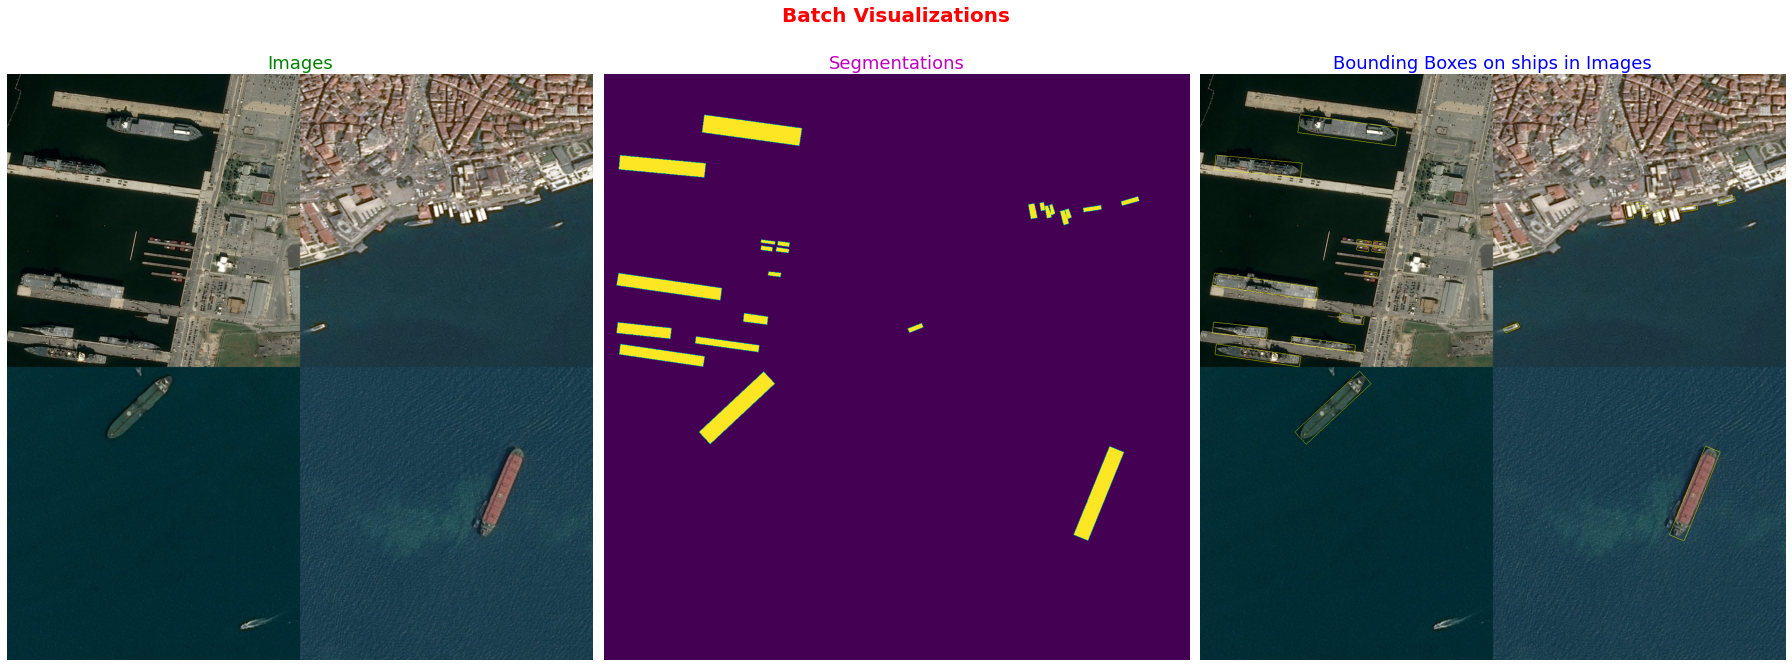

In [51]:
# Visulaising train batch
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
batch_rgb = montage_rgb(train_x)                                                   # Create montage of img
batch_seg = montage(train_y[:, :, :, 0])                                           # Create montafe of msk
batch_overlap = mark_boundaries(batch_rgb, batch_seg.astype(int))                  # Create bounding box around ships in img
titles = ["Images", "Segmentations", "Bounding Boxes on ships in Images"]          # Titles for subplot
colors = ['g', 'm', 'b']                                                           # Colors to be used for title
display = [batch_rgb, batch_seg, batch_overlap]                                    # What to display in subplot
plt.figure(figsize=(25,10))                                                        # Generate figure 
for i in range(3):                                                                 # For i = 0, 1, 2, 3                           
    plt.subplot(1, 3, i+1)                                                         # Create subplot
    plt.imshow(display[i])                                                         # Display 
    plt.title(titles[i], fontsize = 18, color = colors[i])                         # Title 
    plt.axis('off')                                                                # Turn off the axis
plt.suptitle("Batch Visualizations", fontsize = 20, color = 'r', weight = 'bold')  # Add suptitle
plt.tight_layout()                                                                 # Layout for subplot

In [52]:
# Prepare validation data
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(f"valid_x ~\nShape: {valid_x.shape}\nMin value: {valid_x.min()}\nMax value: {valid_x.max()}")
print(f"\nvalid_y ~\nShape: {valid_y.shape}\nMin value: {valid_y.min()}\nMax value: {valid_y.max()}")

MemoryError: Unable to allocate 5.27 GiB for an array with shape (400, 768, 768, 3) and data type float64

In [ ]:
# Augmenting Data using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparing image data generator arguments
dg_args = dict(rotation_range = 15,            # Degree range for random rotations
               horizontal_flip = True,         # Randomly flips the inputs horizontally
               vertical_flip = True,           # Randomly flips the inputs vertically
               data_format = 'channels_last')  # channels_last refer to (batch, height, width, channels)

In [ ]:
image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    '''
    Takes in -
    in_gen - train data generator, seed value
    '''
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))  # Randomly assign seed value if not provided
    for in_x, in_y in in_gen:                                                    # For imgs and msks in train data generator
        seed = 12                                                                # Seed value for imgs and msks must be same else augmentation won't be same
        
        # Create augmented imgs
        g_x = image_gen.flow(255*in_x,                                           # Inverse scaling on imgs for augmentation                                       
                             batch_size = in_x.shape[0],                         # batch_size = 3
                             seed = seed,                                        # Seed
                             shuffle=True)                                       # Shuffle the data
        
        # Create augmented masks
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],                       
                             seed = seed,                                         
                             shuffle=True)                                       
        
        '''Yeilds - augmented scaled imgs and msks array'''
        yield next(g_x)/255.0, next(g_y)

In [ ]:
# Augment the train data
cur_gen = create_aug_gen(train_gen, seed = 42)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

In [ ]:
# Preprocess input for ResNet50
preprocess_input = sm.get_preprocessing(BACKBONE)
train_x = preprocess_input(train_x)
valid_x = preprocess_input(valid_x)

In [ ]:
# Check the shapes and values of validation data
print(f"valid_x shape: {valid_x.shape}, dtype: {valid_x.dtype}")
print(f"valid_y shape: {valid_y.shape}, dtype: {valid_y.dtype}")
print(f"valid_x min: {np.min(valid_x)}, max: {np.max(valid_x)}")
print(f"valid_y min: {np.min(valid_y)}, max: {np.max(valid_y)}")

# Ensure validation masks are binary and correctly shaped
valid_y = (valid_y > 0).astype(np.float32)
valid_x = preprocess_input(valid_x)
print(f"After preprocessing, valid_x shape: {valid_x.shape}, valid_y shape: {valid_y.shape}")
print(f"NaN in valid_x: {np.isnan(valid_x).sum()}")
print(f"NaN in valid_y: {np.isnan(valid_y).sum()}")


In [ ]:
gc.collect() # Block all the garbage that has been generated

In [ ]:
from keras import models, layers
from keras.applications import ResNet50
from keras.layers import BatchNormalization

# Conv2DTranspose upsampling
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

# Upsampling without Conv2DTranspose
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

# Upsampling method choice
if UPSAMPLE_MODE == 'DECONV':
    upsample = upsample_conv
else:
    upsample = upsample_simple

# Load ResNet50 model without the top layers
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=t_x.shape[1:])
resnet50.trainable = False  # Freeze the ResNet50 layers

# Define the U-Net model using ResNet50 as the encoder
input_img = layers.Input(t_x.shape[1:], name='RGB_Input')
pp_in_layer = input_img

# If NET_SCALING is defined then do the next step else continue ahead
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)

# To avoid overfitting and fastening the process of training
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)  # Useful to mitigate overfitting
pp_in_layer = layers.BatchNormalization()(pp_in_layer)  # Allows using higher learning rate without causing problems with gradients

# Pass through the ResNet50 model
resnet_output = resnet50(pp_in_layer)

# Extract the relevant intermediate layers from ResNet50 for U-Net skip connections
c1 = resnet50.get_layer("conv1_relu").output  # 64x64x64
c2 = resnet50.get_layer("conv2_block3_out").output  # 32x32x256
c3 = resnet50.get_layer("conv3_block4_out").output  # 16x16x512
c4 = resnet50.get_layer("conv4_block6_out").output  # 8x8x1024
c5 = resnet50.get_layer("conv5_block3_out").output  # 4x4x2048

## Upsample (U --> Concat --> C --> C)

u6 = upsample(1024, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c6)

u7 = upsample(512, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c7)

u8 = upsample(256, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u8)
c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c8)

u9 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)

if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

resnet50_unet = models.Model(inputs=[input_img], outputs=[d])

resnet50_unet.summary()

In [ ]:
# Compute dice coefficient, loss with BCE and compile the model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# Dice Coefficient
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# Dice with BCE Loss
def dice_p_bce(y_true, y_pred):
    # Binary Cross-Entropy loss
    bce_loss = binary_crossentropy(y_true, y_pred)
    
    # Dice coefficient loss
    dice_loss = 1 - dice_coef(y_true, y_pred)
    
    # Combined loss
    alpha = 1e-3
    combo_loss = bce_loss + alpha * dice_loss
    
    return combo_loss
# Compile the model
resnet50_unet.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef])

In [ ]:
# Preparing Callbacks
# Preparing Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Best model weights
weight_path = "{}_weights.best.weights.h5".format('resnet50_unet')
print(type(weight_path))
# Monitor validation dice coeff and save the best model weights
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

# Reduce Learning Rate on Plateau
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, verbose=1, mode='max', 
                                   min_delta=0.0001, cooldown=2, min_lr=1e-6)

# Stop training once there is no improvement seen in the model
early = EarlyStopping(monitor="val_dice_coef", mode="max", patience=10)

# Callbacks ready
callbacks_list = [checkpoint, early, reduceLROnPlat]
print([type(callback) for callback in callbacks_list])


In [ ]:
# # Finalizing steps per epoch
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0] // BATCH_SIZE)

# Final augmented data being used in training
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))

# Save loss history while training
loss_history = [resnet50_unet.fit(
                                        aug_gen, 
                                        steps_per_epoch=step_count, 
                                        epochs=NB_EPOCHS, 
                                        validation_data=(valid_x, valid_y),
                                        callbacks=callbacks_list,
                                        )]



In [ ]:
# Save the weights to load it later for test data 
# resnet50_unet.load_weights("C:/Users/krish/Downloads/resnet50_unet_weights.best.weights.h5")
resnet50_unet.save('resnet50_unet.h5')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
import cv2

# Define image dimensions and path to the test directory
IMG_HEIGHT = 768  # Change this to your image height
IMG_WIDTH = 768   # Change this to your image width
TEST_DIR = r'E:/test_v2'  # Use raw string literal for Windows paths
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix
import seaborn as sns

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

y_true = valid_y.flatten()
y_pred = resnet50_unet.predict(valid_x).flatten()
# Plot ROC curve
plot_roc_curve(y_true, y_pred)




In [ ]:
# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Flatten predictions and true labels
y_true = valid_y.flatten()
y_pred = resnet50_unet.predict(valid_x).flatten()
plot_precision_recall_curve(y_true, y_pred)

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred)


In [ ]:
# Load the trained model with custom objects
custom_objects = {'dice_coef': dice_coef}

# Define image dimensions and path to the test directory
IMG_HEIGHT = 768  # Change this to your image height
IMG_WIDTH = 768   # Change this to your image width
TEST_DIR = r'E:/test_v2'  # Use raw string literal for Windows paths

# Define a function to load and preprocess test images
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img

# Define a function to post-process the predicted mask to extract bounding boxes
def get_bounding_boxes(prediction, threshold=0.15):
    prediction = prediction[0, :, :, 0]  # Extract the single channel
    prediction = (prediction > threshold).astype(np.uint8)  # Apply threshold to binarize
    contours, _ = cv2.findContours(prediction, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    return bounding_boxes

# Define a function to display the results
def display_results(image_name, test_image, prediction, bounding_boxes):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Test Image: {image_name}')
    plt.imshow(test_image[0])
    
    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(prediction[0, :, :, 0], cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title('Bounding Boxes')
    img_with_boxes = (test_image[0] * 255).astype(np.uint8)  # Convert back to uint8
    for box in bounding_boxes:
        x, y, w, h = box
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(img_with_boxes)
    
    plt.show()

# Iterate over all images in the test directory and display the results
for image_name in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, image_name)
    
    # Load and preprocess the test image
    test_image = load_and_preprocess_image(image_path)
    
    # Make a prediction
    prediction = resnet50_unet.predict(test_image)
    
    # Get bounding boxes from the prediction
    bounding_boxes = get_bounding_boxes(prediction)
    
    # Display the test image, predicted mask, and bounding boxes
    display_results(image_name, test_image, prediction, bounding_boxes)